#### This notebook will be comparing the different industry face recognition models


## 1. Facenet model
FaceNet is a facial recognition system developed by Google researchers Florian Schroff, Dmitry Kalenichenko, and James Philbin. The system uses a deep convolutional neural network to learn a mapping from a set of face images to a 128-dimensional Euclidean space.

### Key Features
Triplet Loss Function: FaceNet uses a novel loss function called “triplet loss” to train the network.
Online Triplet Mining Method: The system introduced a new online triplet mining method to select the most informative triplets for training.
128-Dimensional Euclidean Space: The network maps face images to a 128-dimensional Euclidean space, where the similarity between faces is assessed based on the square of the Euclidean distance between the images’ corresponding normalized vectors.
Architecture
The FaceNet model uses two types of architectures, NN1 and NN2, which differ in the number of parameters and FLOPS. The NN1 model has 140 million parameters and 1.6 billion FLOPS per image.

### Training
The network is trained using stochastic gradient descent with standard backpropagation and the Adaptive Gradient Optimizer (AdaGrad) algorithm. The learning rate is initially set at 0.05 and later lowered while finalizing the model.

### Performance
FaceNet achieved an accuracy of 99.63% on the Labeled Faces in the Wild (LFW) dataset, which is the highest score to date on LFW in the unrestricted with labeled outside data protocol. On YouTube Faces DB, the system achieved an accuracy of 95.12%.

In [20]:
!pip3 install keras torchvision pandas seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image


workers = 0 if os.name == 'nt' else 4

workers

/Users/soubhikghosh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/soubhikghosh/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


In [6]:
def collate_fn(x):
    return x[0]


In [7]:
dataset = datasets.ImageFolder('./data/lfw')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=0) #num_workers disabled as multiprocessing not supported

In [8]:
for idx, (x, y) in enumerate(loader):
    print(f"Image {idx}, Class: {dataset.idx_to_class[y]}")


Image 0, Class: AJ_Cook
Image 1, Class: AJ_Lamas
Image 2, Class: Aaron_Eckhart
Image 3, Class: Aaron_Guiel
Image 4, Class: Aaron_Patterson
Image 5, Class: Aaron_Peirsol
Image 6, Class: Aaron_Peirsol
Image 7, Class: Aaron_Peirsol
Image 8, Class: Aaron_Peirsol
Image 9, Class: Aaron_Pena
Image 10, Class: Aaron_Sorkin
Image 11, Class: Aaron_Sorkin
Image 12, Class: Aaron_Tippin
Image 13, Class: Abba_Eban
Image 14, Class: Abbas_Kiarostami
Image 15, Class: Abdel_Aziz_Al-Hakim
Image 16, Class: Abdel_Madi_Shabneh
Image 17, Class: Abdel_Nasser_Assidi
Image 18, Class: Abdel_Nasser_Assidi
Image 19, Class: Abdoulaye_Wade
Image 20, Class: Abdoulaye_Wade
Image 21, Class: Abdoulaye_Wade
Image 22, Class: Abdoulaye_Wade
Image 23, Class: Abdul_Majeed_Shobokshi
Image 24, Class: Abdul_Rahman
Image 25, Class: Abdulaziz_Kamilov
Image 26, Class: Abdullah
Image 27, Class: Abdullah
Image 28, Class: Abdullah
Image 29, Class: Abdullah
Image 30, Class: Abdullah_Ahmad_Badawi
Image 31, Class: Abdullah_Gul
Image 32, 

In [9]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999919
Face detected with probability: 1.000000
Face detected with probability: 0.999950
Face detected with probability: 0.999999
Face detected with probability: 0.999990
Face detected with probability: 0.999929
Face detected with probability: 0.999997
Face detected with probability: 0.999784
Face detected with probability: 0.999962
Face detected with probability: 0.999975
Face detected with probability: 0.999981
Face detected with probability: 0.999980
Face detected with probability: 0.999989
Face detected with probability: 0.999971
Face detected with probability: 0.999997
Face detected with probability: 0.999998
Face detected with probability: 0.999868
Face detected with probability: 0.999998
Face detected with probability: 0.999999
Face detected with probability: 0.999498
Face detected with probability: 0.999691
Face detected with probability: 0.998619
Face detected with probability: 0.999993
Face detected with probability: 0.999652
Face detected wi

In [10]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

: 

In [17]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  \
angelina_jolie        0.000000        1.447480     0.887728   1.434377   
bradley_cooper        1.447480        0.000000     1.313749   1.011981   
kate_siegel           0.887728        1.313749     0.000000   1.388993   
paul_rudd             1.434377        1.011981     1.388993   0.000000   
shea_whigham          1.399073        1.038684     1.379655   1.104095   

                shea_whigham  
angelina_jolie      1.399073  
bradley_cooper      1.038684  
kate_siegel         1.379655  
paul_rudd           1.104095  
shea_whigham        0.000000  


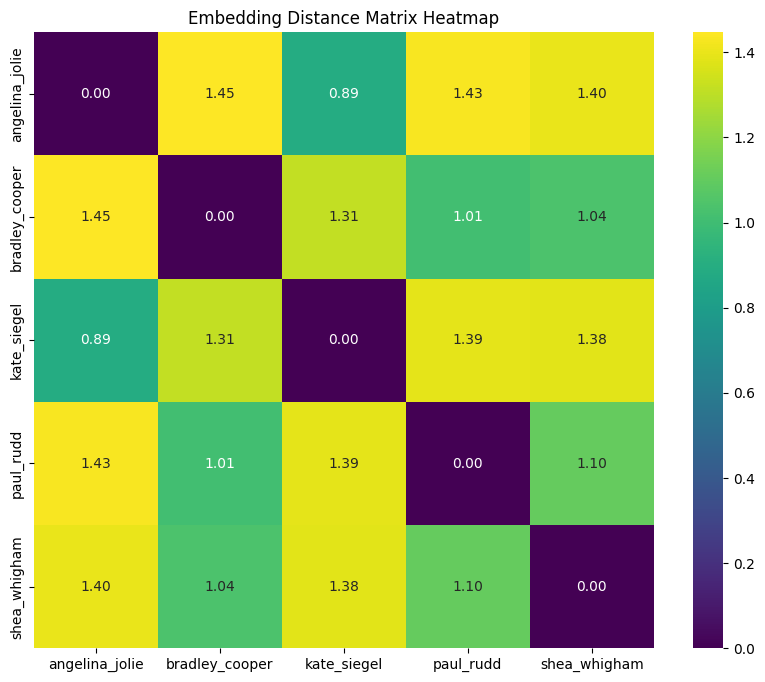

In [22]:
# Assuming 'dists' contains the distance matrix and 'names' contains labels
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
df_dists = pd.DataFrame(dists, columns=names, index=names)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_dists, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Embedding Distance Matrix Heatmap")
plt.show()


In [31]:
def classify_image(image_path):
    # Load and preprocess the random image
    img = Image.open(image_path).convert('RGB')
    img_cropped, prob = mtcnn(img, return_prob=True)
    
    if img_cropped is None:
        print("No face detected in the input image.")
        return None
    
    print(f"Face detected in input image with probability: {prob:.8f}")
    
    # Compute embedding for the random image
    img_embedding = resnet(img_cropped.unsqueeze(0).to(device)).detach().cpu()
    
    # Compute distances between the random image and known embeddings
    distances = [(e - img_embedding).norm().item() for e in embeddings]
    
    # Find the closest match
    closest_idx = np.argmin(distances)
    closest_name = names[closest_idx]
    closest_distance = distances[closest_idx]
    
    print(f"Closest match: {closest_name} (Distance: {closest_distance:.4f})")
    return closest_name, closest_distance

In [34]:
random_image_path = './Face Recognition/soubhik_test.JPG'  # Replace with the path to your random image
classify_image(random_image_path)

Face detected in input image with probability: 0.81875199
Closest match: angelina_jolie (Distance: 1.2967)


('angelina_jolie', 1.2966530323028564)

# APPROACH 2

In [35]:
!pip3 install facenet-pytorch torch torchvision scikit-learn


Defaulting to user installation because normal site-packages is not writeable


/Users/soubhikghosh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/soubhikghosh/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


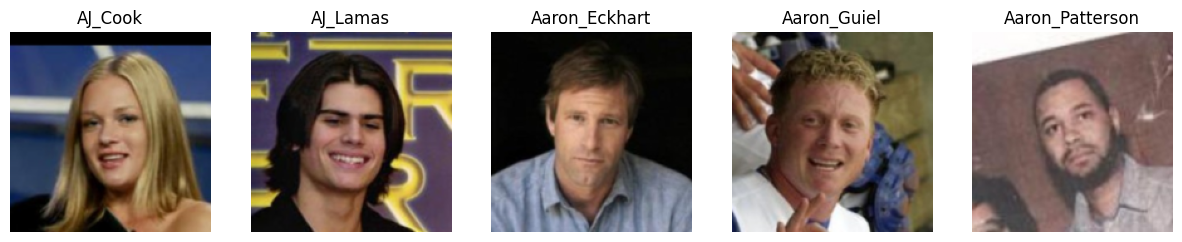

Extracting embeddings: 100%|██████████| 414/414 [16:42<00:00,  2.42s/it]


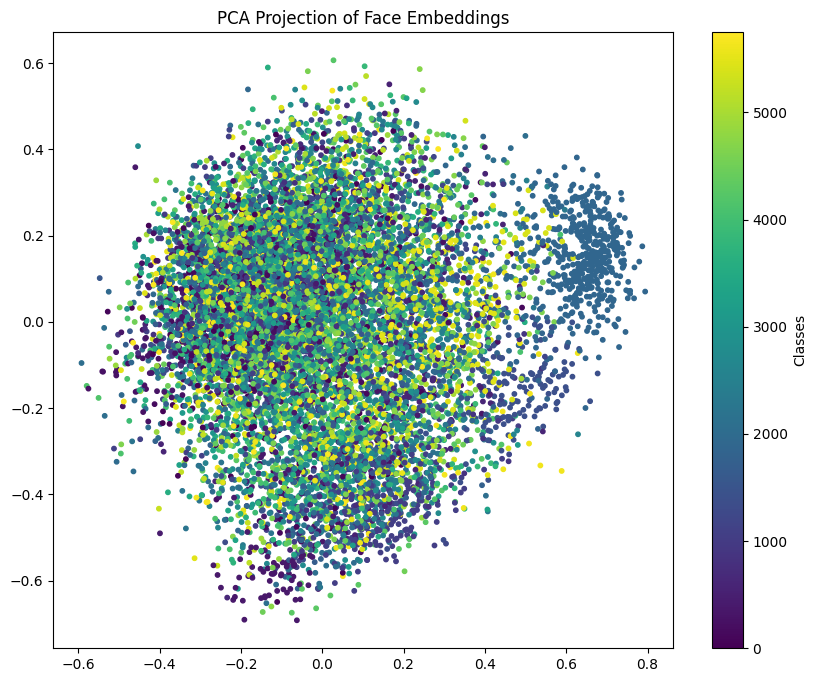

Training classifier...
Predicting on test set...
Accuracy: 43.52%
Classification Report:


ValueError: Number of classes, 1907, does not match size of target_names, 5749. Try specifying the labels parameter

In [ ]:
# Import required libraries
import torch
import numpy as np
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.metrics import accuracy_score, classification_report
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Load FaceNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Initialize the MTCNN for face detection
mtcnn = MTCNN(device=device)

# Prepare a dataset (Example: Load faces dataset)
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Example dataset (You can replace this with your dataset)
dataset = datasets.ImageFolder('path_to_faces_dataset', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Prepare labels
class_names = dataset.classes

# Extract embeddings for the dataset
def extract_embeddings(data_loader, model, device):
    embeddings = []
    labels = []
    for images, targets in data_loader:
        images = images.to(device)
        with torch.no_grad():
            emb = model(images).cpu().numpy()
        embeddings.extend(emb)
        labels.extend(targets.numpy())
    return np.array(embeddings), np.array(labels)

embeddings, labels = extract_embeddings(data_loader, model, device)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

# Train a classifier on the embeddings
from sklearn.svm import SVC
classifier = SVC(kernel='linear', probability=True)
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Calculate accuracy and display a classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))
